<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
!python --version

Python 3.10.9


In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

/home/dzindzers/Desktop/Research/AI_Team/Active Repos/pyJedAI-Dev/pyjedai/matching.py:47: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


ImportError: cannot import name 'Evaluation' from partially initialized module 'pyjedai.evaluation' (most likely due to a circular import) (/home/dzindzers/Desktop/Research/AI_Team/Active Repos/pyJedAI-Dev/pyjedai/evaluation.py)

# Block Building

In [206]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [207]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [208]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0888 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [209]:
from pyjedai.block_cleaning import BlockFiltering

In [210]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [211]:
from pyjedai.block_cleaning import BlockPurging

In [212]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/4932 [00:00<?, ?it/s]

In [213]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3224.0
Runtime: 0.0258 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.86% 
	Recall:        98.88%
	F1-score:       1.70%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1064
	False positives: 122748
	True negatives: 1035016
	False negatives: 12
	Total comparisons: 123812
──────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.8593674280360546,
 'Recall %': 98.88475836431226,
 'F1 %': 1.7039267183396323,
 'True Positives': 1064,
 'False Positives': 122748,
 'True Negatives': 1035016,
 'False Negatives': 12}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [214]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM,
    WhooshPM
)

In [215]:
%%time
ltpm = LocalTopPM(
    budget = 5000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = ltpm.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 2.72 s, sys: 12 ms, total: 2.73 s
Wall time: 2.75 s


In [216]:
%%time
gtpm = GlobalTopPM(
    budget = 5000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = gtpm.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 1.43 s, sys: 11.9 ms, total: 1.44 s
Wall time: 1.45 s


In [217]:
%%time
gpsnm = GlobalPSNM(
    budget = 5000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = gpsnm.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 348 ms, sys: 4.01 ms, total: 352 ms
Wall time: 353 ms


In [218]:
%%time
lpsnm = LocalPSNM(
    budget = 5000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = lpsnm.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 57.9 ms, sys: 3.97 ms, total: 61.9 ms
Wall time: 60.5 ms


In [219]:
%%time
ennbpm = EmbeddingsNNBPM(
    budget = 5000,
    vectorizer = 'sminilm',
    similarity_search = 'faiss',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ennbpm.predict(cleaned_blocks, data, tqdm_disable=True, method='HB', emit_all_tps_stop=False)

Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cpu
Loading embeddings from file...
Loading file:  .embeddings/sminilm_d1_1.npy
Loading file:  .embeddings/sminilm_d2_2.npy
Loading embeddings from file finished
Saving embeddings...
CPU times: user 153 ms, sys: 24.1 ms, total: 177 ms
Wall time: 61.7 ms


In [220]:
%%time
rpm = RandomPM(
    budget = 5000,
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 36.2 ms, sys: 3 µs, total: 36.2 ms
Wall time: 35.7 ms


In [221]:
%%time
pesm = PESM(
    budget = 5000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(cleaned_blocks, data, tqdm_disable=True, method='BFS', emit_all_tps_stop=False)

CPU times: user 5.28 s, sys: 7.93 ms, total: 5.29 s
Wall time: 5.29 s


In [225]:
%%time
whpm = WhooshPM(
    budget = 5000,
    metric='TF-IDF',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

whpm_graph = whpm.predict(cleaned_blocks, data, tqdm_disable=True, method='BFS', emit_all_tps_stop=False)

Applying TF-IDF Similarity Function
CPU times: user 7.47 s, sys: 35.9 ms, total: 7.51 s
Wall time: 7.55 s


In [226]:
matchers_data = []

matchers_data.append(("Random", rpm))
matchers_data.append(("Local Top", ltpm))
matchers_data.append(("Global Top", gtpm))
matchers_data.append(("GSN", gpsnm))
matchers_data.append(("ES-BFS", pesm))
matchers_data.append(("ENNBPM-HB", ennbpm))
matchers_data.append(("WHOOSH-BFS", whpm))

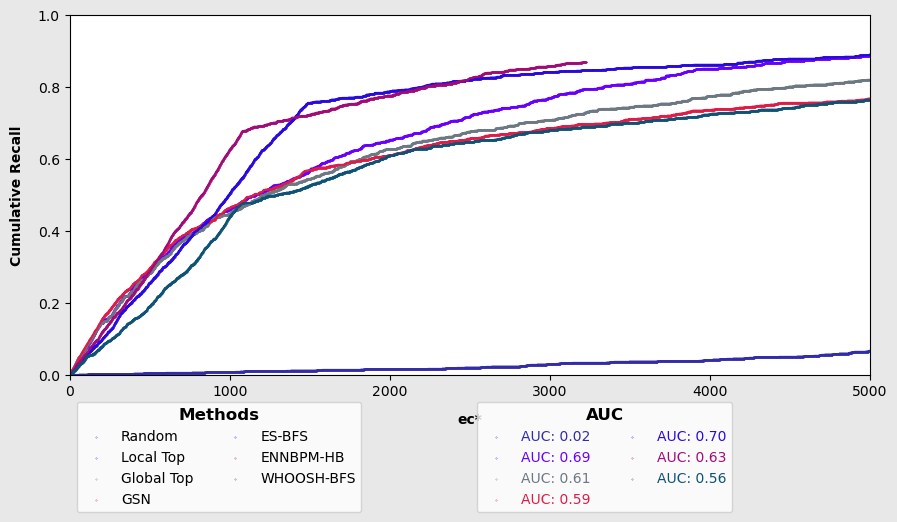

CPU times: user 444 ms, sys: 4 ms, total: 448 ms
Wall time: 451 ms


In [227]:
%%time
progressive_matchers_evaluator = Evaluation(data)
progressive_matchers_evaluator.evaluate_auc_roc(matchers_data = matchers_data, proportional = False)

In [230]:
# After supplying the progressive matchers to AUC ROC evaluation
# You can easily retrieve information about the method's performance using corresponding functions
# You can get the total number of emissions, the final cumulative recall and the normalized AUC

# Example for Entity Scheduling with BFS Method:
print(f'Total Emissions: {pesm.get_total_emissions()}')
print(f'Cumulative Recall: {pesm.get_cumulative_recall()}')
print(f'Normalized AUC: {pesm.get_normalized_auc()}')

Total Emissions: 5000
Cumulative Recall: 0.8894052044609665
Normalized AUC: 0.7003106813581504
